# Text processing with LSTM

In this notebook, we'll try to process Donald Trump speeches using a PyTorch LSTM network and the politic's speeches [dataset](https://github.com/ryanmcdermott/trump-speeches).

## Encoding characters

First thing, let's prepare the `Encoder` class, which would serve as a conversion utility transforming text characters to unambiguous number representation. We will skip any characters that aren't matched by `[a-z0-9 .!?]` regex. Seeing such pattern, one might ask - _What about capital letters?_. Well, we'll convert them to their small equivalents first, skipping this step would result in inconsistent text interpretations.

* The method `__init__` takes the string serving as alphabet as argument and creates character to id mappings for each character (and id to character as well).
* The method `__call__` takes one argument, which is either a string or a `torch.Tensor`. If it's a string, it returns its numerical representation as a tensor. If it's a tensor, it works the other way around.

In [1]:
import re
import torch

class Encoder:
    def __init__(self, alphabet: str):
        self.ch2id = dict()
        self.id2ch = dict()
        character_id = 0
        regexp = re.compile(r'[a-z0-9 .!?]')

        for character in alphabet:
            assert re.search(regexp, character), 'Character not matched with the regex [a-z0-9 .!?]'
            if character not in self.ch2id.keys():
                self.ch2id[character] = character_id
                self.id2ch[character_id] = character
                character_id += 1

        self.alphabet_len = len(self.ch2id.keys())

    def __call__(self, input_text: [str, torch.Tensor]):
        input_type = type(input_text)
        assert input_type in (str, torch.Tensor), 'This input type is not available, please use string or torch.Tensor'

        result_list = []

        if input_type == str:
            for character in input_text:
                if ord(character) in range(ord('A'), ord('Z') + 1):
                    character = chr(ord(character) - ord('A') + ord('a'))

                if character in self.ch2id.keys():
                    result_list.append(self.ch2id[character])

            return torch.tensor(result_list)
        else:
            for character_id in input_text:
                result_list.append(self.id2ch[character_id.item()])

            return ''.join(result_list)

## Dataset

We need a class to encapsulate our dataset, hence the implementation of `TextDataset` that derives from `torch.utlis.data.Dataset`. It wraps a text file and utilizes it for training with PyTorch.

* The method `__init__` takes a path to a text file as string and an integer `l` specifying the length of one sample sequence.
* The method `__len__` takes no arguments and returns the size of the dataset.
* The method `__getitem__` takes an integer indexing a sample sequence and should return that sequence as a `torch.Tensor`.

The way we will handle our source text is as follows: the whole file can be viewed as one long sequence. We split this sequence into samples of length `l`. These samples are then used in the training loop, more details there.

One tweak worth mentioning here - I'm swapping all newline signs `\n` for spaces and eliminating multiple whitespaces in the process.

In [2]:
import torch
from torch.utils.data import Dataset


class TextDataset(Dataset):
    def __init__(self, txt_filepath: str, l: int):
        alphabet = ''.join([chr(_) for _ in range(ord('a'), ord('z') + 1)]) + ''.join([str(_) for _ in range(10)]) + ' .?!'
        self.encoder = Encoder(alphabet)

        with open(txt_filepath, 'r', encoding='utf8') as file:
            text = re.sub(' {2,}', ' ', file.read().replace('\n', ' '))

        encoded = self.encoder(text)
        self.samples = torch.split(encoded, l)

        if len(self.samples[-1]) < l:
            self.samples = self.samples[:-1]

        self.samples_len = len(self.samples)

    def __len__(self):
        return self.samples_len

    def __getitem__(self, i) -> torch.Tensor:
        return self.samples[i]


## The Model

We write a class `NextCharLSTM` that derives from `torch.nn.Module` and takes `alphabet_size`, the `embedding_dim`, and the `hidden_dim` as arguments. As mentioned earlier, it consists of a `torch.nn.Embedding` layer mapping the alphabet to embeddings, a `torch.nn.LSTM` that takes the embeddings as inputs and maps them to hidden states, and a `torch.nn.Linear` output layer that maps the hidden states of the LSTM back to the alphabet.

* The method `__init__` sets up the module
* The method `forward` takes an input sequence and returns the logits of the model prediction at every time step

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class NextCharLSTM(nn.Module):
    def __init__(self, alphabet_size: int, embedding_dim: int, hidden_dim: int):
        super().__init__()

        self.embedding = nn.Embedding(num_embeddings=alphabet_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, alphabet_size)

    def forward(self, x):
        emb = self.embedding(x)
        hidden, _ = self.lstm(emb)
        return self.linear(hidden)

## Training/Validation Epoch

We implement a function `epoch` that takes a `torch.utils.data.DataLoader`, a `NextCharLSTM`, and a `torch.optim.Optimizer` as arguments, where the last one might be `None`. If the optimizer is `None`, then the function validates the model. Otherwise, it trains the model for next-character prediction in the many-to-many setting. That is, given a sequence `x` of length `l`, the input sequence is `x[:l-1]` and the corresponding target sequence is `x[1:]`. The function performs one epoch of training/validation and returns the loss values of each mini batch as a `np.ndarray`. We use the `CrossEntropyLoss` function for both training and validation.

In [4]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

loss_fn = nn.CrossEntropyLoss()

def epoch(data: DataLoader, model: NextCharLSTM, opt: torch.optim.Optimizer=None):
    losses = []
    train = opt is not None

    for batch in data:
        x_batch = batch.cuda()
        x, y = x_batch[:,:-1], x_batch[:,1:]

        if train:
            model.train()
            opt.zero_grad()
            logits = model(x).permute(0, 2, 1)
        else:
            model.eval()
            with torch.no_grad():
                logits = model(x).permute(0, 2, 1)

        loss = loss_fn(logits, y)
        losses.append(loss.item())

        if train:
            loss.backward()
            opt.step()

    return np.asarray(losses)

## Model Selection

We train the model for 30 epochs using `torch.optim.Adam`. After every epoch, the model is validated. On top of that, if the model outperforms the best model yet on the validation set, the better one is saved.

In [5]:
import matplotlib.pyplot as plt

sequence_length = 100
batch_size = 256
embedding_dim = 8
hidden_dim = 512
learning_rate = 1e-3
num_epochs = 30
alphabet = ''.join([chr(_) for _ in range(ord('a'), ord('z') + 1)]) + ''.join([str(_) for _ in range(10)]) + ' .?!'
alphabet_size = len(alphabet)

model_path = './model.pt'

train_dataset = TextDataset('./dataset/trump_train.txt', sequence_length)
val_dataset = TextDataset('./dataset/trump_val.txt', sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = NextCharLSTM(alphabet_size, embedding_dim, hidden_dim).cuda()
opt = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate
)

train_losses = []
val_losses = []
best_val_loss = 9999

for n_epoch in tqdm(range(num_epochs)):
    train_losses.append(epoch(train_loader, model, opt).mean())
    val_loss = epoch(val_loader, model).mean()
    val_losses.append(val_loss)

    if val_loss < best_val_loss:
        torch.save(model.state_dict(), model_path)
        best_val_loss = val_loss

100%|██████████| 30/30 [01:00<00:00,  2.01s/it]


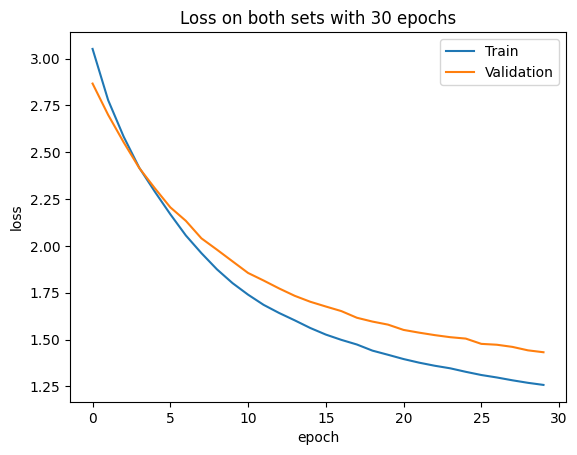

In [6]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f'Loss on both sets with {num_epochs} epochs')
plt.legend(['Train', 'Validation'])
plt.show()

## Top-k Accuracy

Before we proceed to show results of our training, let's propose additional metric: top-k accuracy.

Here we define a function for that - it computes accuracies for each value of k in the argument `k`, namely average of accuracies over all batches of samples. A sample is considered to be classified correctly if the true label appears in the top-k classes predicted by the model.

In [7]:
from typing import List

def topk_accuracy(k: List[int], model: NextCharLSTM, data: DataLoader):
    accuracies = []
    for k_value in tqdm(k):
        hits = 0
        total = 0

        for batch in data:
            batch = batch.cuda()
            x, y = batch[:,:-1], batch[:,1:]

            with torch.no_grad():
                logits = model.forward(x)
                top_k = torch.topk(logits, k_value).indices

                for batch_top_indices, batch_true_labels in zip(top_k, y):
                    for top_indices, true_label in zip(batch_top_indices, batch_true_labels):
                        if true_label in top_indices:
                            hits += 1

            total += len(batch)

        acc = hits / total
        accuracies.append(acc)

    return accuracies

In [8]:
best_model = NextCharLSTM(alphabet_size, embedding_dim, hidden_dim).cuda()
best_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [9]:
all_ks = [k for k in range(1, alphabet_size + 1)]
best_model_k_accuracies = topk_accuracy(all_ks, best_model, val_loader)

100%|██████████| 40/40 [01:03<00:00,  1.59s/it]


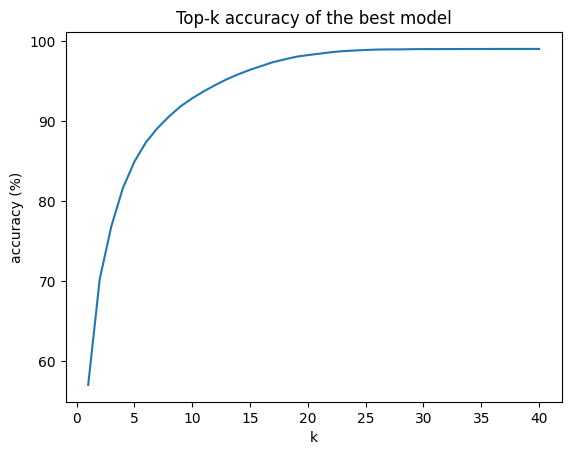

In [10]:
plt.plot(all_ks, best_model_k_accuracies)
plt.xlabel('k')
plt.ylabel('accuracy (%)')
plt.title('Top-k accuracy of the best model')
plt.show()

## Gumbel-Max Character Sampling

In this part, we utilize the trained network to generate novel text. We introduce a function for convenient text generation, depending on seed text and tau value, which I will explain shortly.

As an addition to trivial text generation, we will use the so-called Gumbel-Max trick. Its purpose is to sample the next predicted character from a categorical distribution rather than always pick one with the biggest probability.

The formula for this distribution is as follows:

$$
\pi_k = \frac{e^{z_k / \tau}}{\sum_{j=1}^K e^{z_j / \tau}}
$$

where $z_k$ is output logit of a character with index k and $\tau > 0$ is the temperature. For $\tau \to 0$ we approach the one-hot distribution, whereas for $\tau \to \infty$ we approach the uniform distribution. The Gumbel-Max trick says that the random variable

$$
Y = \arg \max_{k \in 1, \dots, K} (z_k / \tau + \xi_k) 
$$

follows a categorical distribution parameterized by $\pi_1, \dots, \pi_K$, where $\xi_k$ is drawn independently of the standard Gumbel distribution.

In [11]:
from torch.distributions.gumbel import Gumbel


def generate_text(seed_text: str, tau=1., generated_text_len=200):
    e = Encoder(alphabet)

    for _ in range(generated_text_len):
        encoded = e(seed_text[-200:]).unsqueeze(0).to(torch.int64).cuda()

        with torch.no_grad():
            pred = best_model(encoded)[:,-1]

        gumbel = Gumbel(0, 1)
        xi = gumbel.sample(pred.size()).cuda()
        output = torch.argmax(pred / tau + xi, dim=-1)
        decoded = e(output)
        seed_text = seed_text + decoded

    return seed_text

Now, we will try different $\tau$ values so that we find an optimum.

In [12]:
for tau in [0.01, 0.1, 0.3, 0.5, 0.75, 1, 5]:
    generated = generate_text('good evening', tau)
    print(f'Tau={tau}\nText={generated}')

Tau=0.01
Text=good evening the press that we have to be a lot of the people that was a lot of the polls and they dont know what they dont want to have the press that we have to be a lot of the polls and they dont know what i w
Tau=0.1
Text=good evening the state of the people that we have to be a lot of the people that we have to do that they dont know what they dont know what i was a lot of the polls that was a lot of money and i want to the press
Tau=0.3
Text=good evening the press that was a treated states that we have to be a tremendous is a states and they have to say the wall is they want to be a lot of the people that was a big deal we could have to the country a
Tau=0.5
Text=good evening a lot of money on cant be the way you know what it was like this mexico they are we have to do it will be a disaster that dont know theyd like the wall. we have to do that they dont want to do it. th
Tau=0.75
Text=good evening the united states. they said it was for president i think were going

In [20]:
for tau in [0.5, 0.6, 0.7, 0.8]:
    generated = generate_text('good evening', tau)
    print(f'Tau={tau}\nText={generated}')

Tau=0.5
Text=good evening the press and i think that we have to see what i was a hat one people are going to be very much. we have to have make a lot of the furted and they they say theyre going to can deal with the right tho
Tau=0.6
Text=good evening the big tong and they she would be the hist. be the most was thing in the should have the businessed the state days president that we will have  they dont want to have a couple of the empst of the pe
Tau=0.7
Text=good evening it incredible but theyre not becamse one that dont have a tacks one it all the most newtlay terrarild. they dont even know what i wantid ub the greatest people. but they want to them building for the
Tau=0.8
Text=good evening trump. you know kide make our military is going to think you know anybody. so kay for the largeds in the balks they have so because its right to have to be whole about at our american in the things l


Let's see the final text, with optimal tau and a bit expanded seed text.

In [21]:
generate_text('Good evening americans', tau=0.65, generated_text_len=1000)

'Good evening americans done the good minds they said i mean that are going to have a great campaign this clunted have treat destory and it was not going to build the border and we have to back. and i will have will were going to be anybody. i dont know how to see who dont want to happen. they are for the people we will be but i really were and then i have for president. but thats what were going to happen were going to get a poll  they could have been the press taxe about the fumplisy dont know our military been anybody were going to make a money in strongs to leavely in factines has done. we wele are going to get a lot of like this room not hillary clinton people in the story than to me and you look there when you have to me so many sayited it was going to have been really end of it was different said i have a lot of and i said and you know we have not going to be paterally and they have truen a bad the greatest because i dont say that it was great people. they dont look for here and